In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [1]:
import time
import ast
from obtain_wiki_data import create_link_list, network_step
from graphing import get_paths, graph_multiprocessing_failures, graph_network, graph_philosophy_depth, plot_frequency
from follow_first_link import follow_first_links

# What is the most common link on Wikipedia?
**A Computational Essay by Daniel Heitz and Brooke Wager**
## Introduction
Wikipedia is a treasure trove of information. One notable aspect of this website is the way that pages are linked within each other, which allows more context on topics mentioned within a page. The operation of these links has led to the creation of games such as "Getting to Philosophy" and "5-Steps to Jesus" that revolve around the successive clicking of links. We decided that we wanted to gather statistics on the most popular links on Wikipedia as well map routes produced by clicking on the first link of a page as is done in games like "Getting to Philosophy."

## What is the most common link?
This was our primary exploratory question, and to answer it we generated a pool of worker processes that use the `wikipedia` library to get random pages using our `random_page()` function and generate lists of all the links on each of the pages. We then graph the frequency of those links. `create_link_list()` creates the pool of workers and returns all of their results collected into a nested list. As a warning, many of our functions will produce error messages but still run to completion, this is completely normal and is due to mistakes on the server side. They are uncommon but with the amount of requests we issue they show up fairly often, do not be alarmed the output is still valid, the bad requests are just skipped.

In [ ]:
# Creates a list of links and saves to a file
# You can ignore this cell if the data is already generated

all_links = create_link_list(threads=20,depth=500)

# Write to file
with open('links.txt', 'w+') as file:
    for link_list in all_links:
        for link in link_list:
            file.write('%s\n' %link)

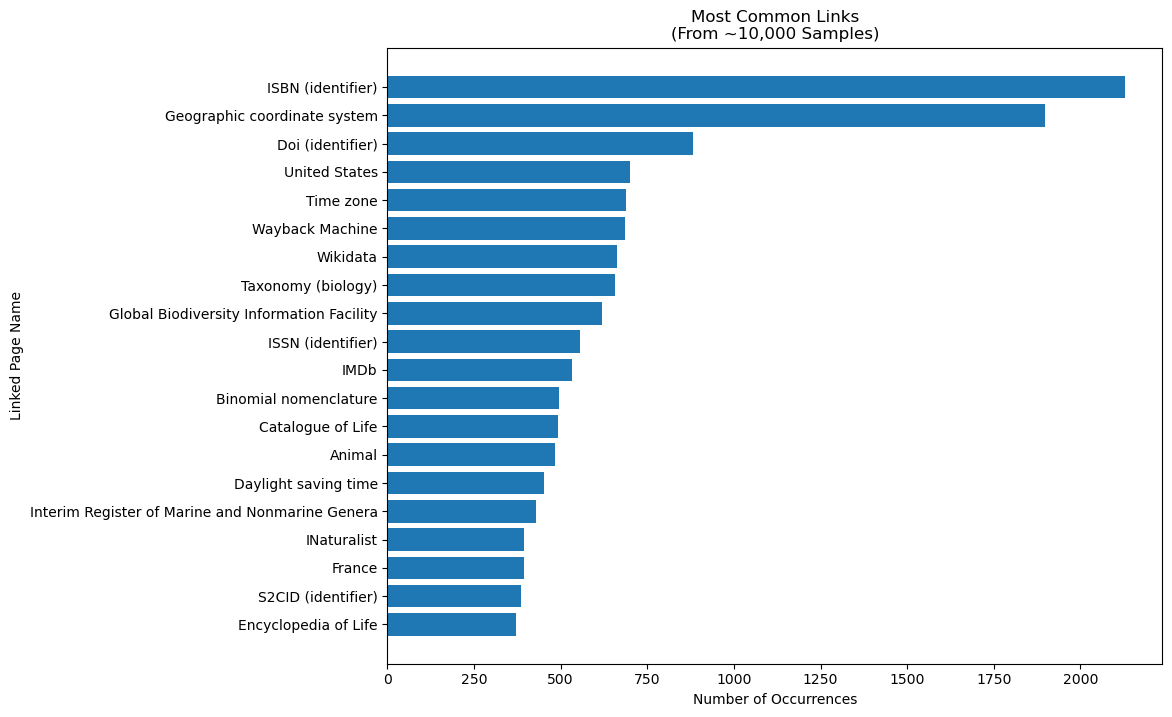

In [3]:
# Reads from the file generated above and creates a frequency graph

all_links = []
with open("links.txt") as file:
    for line in file:
        all_links.append(line.rstrip())

plot_frequency(all_links, f"Most Common Links\n(From ~10,000 Samples)", 
               flat=True)

This was very interesting, neither of us was expecting ISBN to be the most popular. We did some digging and found out that ISBN is linked any time a book is cited. Our algorithm only counts the first time a link appears on a page if there are duplicates, but still, this suggests that books are an extremely popular source on Wikipedia. If you'll notice, DOI is on there but is a distant third. DOI is used for digital articles and documents or other such artifacts. Geographic Coordinate System being second also tells us quite a lot. This suggests that places are one of, if not the most popular, type of page on Wikipedia. This is because any time you visit the page of a place, you'll find the geographic coordinates in the top corner along with the link to the page for the Geographic Coordinate System. However, this does not prove that places are the most popular page on Wikipedia, because there could be another larger category that lacks a consistent link such as this. In order to visualize how pages connect to each other, we picked random pages and followed random links on them using `network_step()` via the multiprocessing wrapper `get_paths()`. The data from `get_paths()` is a list of ordered lists where each interior list represents the sequence of articles `depth + 1` articles that the respective worker explored. `graph_network()` takes this data, generates edges between nodes based on the order of the data from `get_paths()` removes duplicate nodes, then graphs them as a network using PyGraphViz. The original graph is saved in `"best_network.png"`. It is a very large image file and you will likely need to view it in a dedicated image viewer. If you notice, the whole graph is clustered around ISBN as the nexus of the paths, which could be expected as it is the most common link. Below is the code to generate a new random network, which will be saved as `"random_network.png"`.

In [ ]:
graph_network(get_paths(25, 1000, network_step), "random_network.png")

## What is the most common first link?

We know the most common link overall, but now we'd like to take a look at statistics relevant to the "Getting to Philosophy" game. This game depends on clicking on the first link on every page, so we do just that. We actually need to do a fair bit of parsing since the `wikipedia` library's links function automatically alphabetizes them. We do this in the `scan_links()` function, which is a helper function for our `follow_first_links()` function.


In [ ]:
# Creates a list of links and saves to a file
# You can ignore this cell if the data is already generated
# WARNING: WILL TAKE AT LEAST 2 HOURS

paths = []
for i in range(4):
    for j in range(125):
        print(i*125+j)
        paths.append(follow_first_links(depth=1,threads=10))
    time.sleep(60)  # Pause to prevent DDOSing

with open('first_links.txt', 'w+') as file:
    # write elements of list
    for worker in paths:
        for path in worker:
            file.write('%s\n' %path)

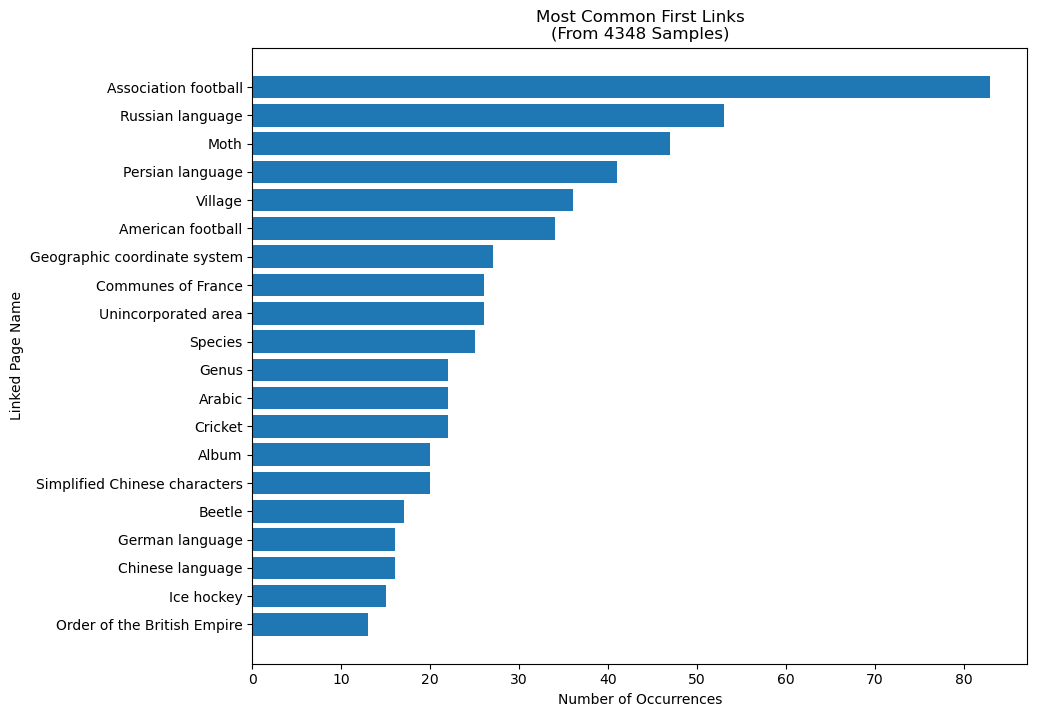

In [64]:
# Reads from the file generated above and creates a frequency graph

with open('first_links.txt', 'r') as file:
    first_titles = []
    no_first_link = 0
    for line in file:
        path = ast.literal_eval(line)
        try:
            first_titles.append(path[1])
        except IndexError:
            no_first_link += 1

plot_frequency(first_titles, 
f"Most Common First Links\n(From {len(first_titles) + no_first_link} Samples)", 
flat=True)

We found that the most common first link by far was Association Football (soccer). This makes sense as it is the dominant sport in the world. There are also many languages high up on the list. This is because many pages have different spellings in different languages, and that language is linked first when this happens. What we couldn't really explain was why Moth was third. There are supposedly 160,000 different species of moth, but that doesn't explain why it ranked higher than, say, beetle, which has over 400,000 species.

## Do All First Links Really Lead to Philosophy?

According to Wikipedia in the February 2016, repeatedly clicking the first links of Wikipedia articles will lead to the Philosophy page 97% of the time. We wanted to know how long it would take to reach Philosophy using this method. So, we graphed a histogram of how many links are needed to be clicked to reach Philosophy. Any values less than 0 mean that the original page could not link back to Philosophy.

We were also curious about how the first links connect to each other, so we created another network graph, this time based on `find_first_link()`. This is located in the file `"first_link_network.png()"`. Most of the image is taken up by one large mass in which Philosophy resides. It is clear that there are several central nodes to this network that explain why so many pages can link back to Philosophy. The largest ones appear to be Science and Language. What surprises us about this chart is that Philosophy is only connected to two other pages. The lines on this chart are non-directional, so you cannot discern this from it, but only one page leads to Philosophy: Philosophy of Logic. In fact, everything from starting from Information is a straight line to Philosophy with no other pages leading there. That means that the game should not be called "Getting to Philosophy," but should be renamed to "Getting to Information." We also noticed that the United States also has its own loop and does not lead to Philosophy.

*Disclaimer: our code is not 100% true to the original rules of the "Getting to Philosophy" game. The first rule of the game is that the user clicks on the first link **not** in parentheses and **not** italicized. However, we chose not to recognize parentheses and italics, and so results may differ slightly. There are also some instances where the program chooses a link that is not in the main section of the article because the HTML was poorly structured.*

In [ ]:
# Creates a list of links and saves to a file
# You can ignore this cell if the data is already generated

paths = []
for i in range(5):
    print(i)
    paths.append(follow_first_links(threads=20, depth=100))
    time.sleep(30)  # Pause to prevent DDOSing

with open('first_link_chains.txt', 'w+') as file:
    # write elements of list
    for worker in paths:
        for path in worker:
            file.write('%s\n' %path)

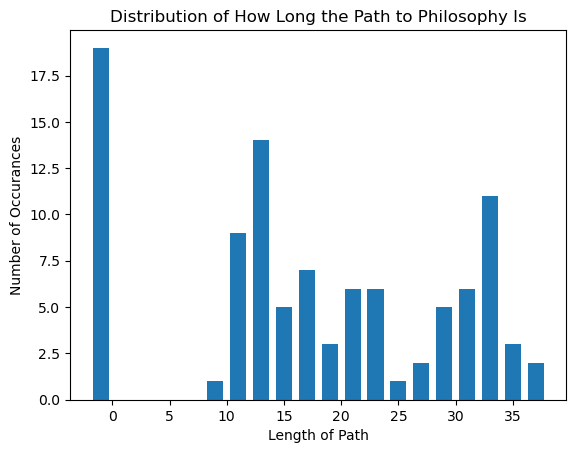

The percentage of pages that link to philosophy is 81%.


In [24]:
# Reads from the file generated above
with open('first_link_chains.txt', 'r') as file:
    chains = []
    for line in file:
        path = ast.literal_eval(line)
        chains.append(path)

# Create a histogram
depth = graph_philosophy_depth(chains)
print(f"The percentage of pages that link to philosophy is {100 * (len(depth) - depth.count(-2)) // len(depth)}%.")

# Create a network graph
graph_network(chains, "random_first_link_network.png")

Based on the histogram, a vast majority of pages end up being able to link to Philosophy. However, 81% is nowhere near the 97% reported in 2016. This is likely due to our program differing slightly from the original rules. It could also be due to the small sample size of 100 pages or the fact that Wikipedia has gained so many articles in the past 7 years.

## Conclusion

The network graphs as well as the bar graphs show that there are very different trends in how common certain first links are versus the overall most common links. This suggests that a different thought process goes towards first links than towards links in general. This is likely because Wikipedia guidelines recommend starting an article by defining the topic the subject resides in, which leads to many articles linking to broader topics.

## Appendix

While we were gathering our data we ran into the issue that our workers could run too fast for Wikipedia to keep up and we started getting empty requests which led to non-fatal errors at runtime. We tweaked the functions so they throw less of these errors by slowing them down, but before doing that we decided to graph these errors just for fun and got the following graph.

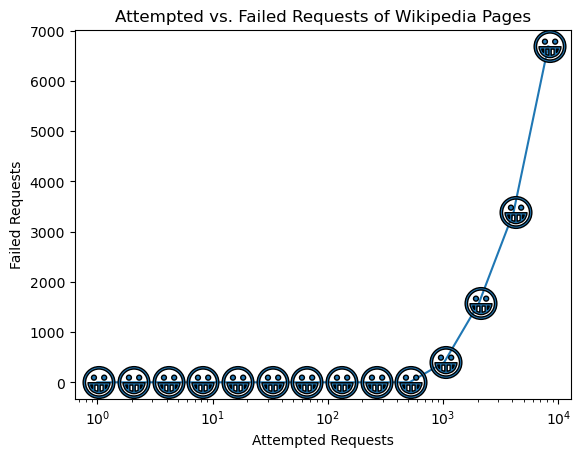

'Joe Mama'

In [62]:
graph_multiprocessing_failures()